In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE

import urllib.request as urllib
import io
import zipfile

In [2]:
# download the football data, and build a graph
url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"

sock = urllib.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read('football.txt').decode()  # read info file
gml = zf.read('football.gml').decode()  # read gml data
# throw away bogus first line with # from mejn files
gml = gml.split('\n')[1:]
G = nx.parse_gml(gml)  # parse gml data

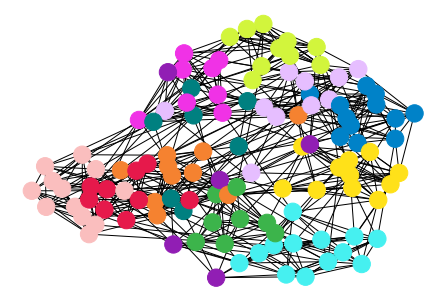

In [3]:
# list of conferences
#   0 - Red      = Atlantic Coast
#   1 - Green    = Big East
#   2 - Yellow   = Big Ten
#   3 - Blue     = Big Twelve
#   4 - Orange   = Conference USA
#   5 - Purple   = Independents
#   6 - Cyan     = Mid-American
#   7 - Magenta  = Mountain West
#   8 - Lime     = Pacific Ten
#   9 - Pink     = Southeastern
#  10 - Teal     = Sun Belt
#  11 - Lavendar = Western Athletic

colors = np.array(
    [[230, 25, 75],
    [60, 180, 75],
    [255, 225, 25],
    [0, 130, 200],
    [245, 130, 48],
    [145, 30, 180],
    [70, 240, 240],
    [240, 50, 230],
    [210, 245, 60],
    [250, 190, 190],
    [0, 128, 128],
    [230, 190, 255]]) / 255

cmap = []
for n in G.nodes:
    # the "value" of each node represents the teams' conferences
    ix = G.nodes[n]['value']
    cmap.append(colors[ix])
nx.draw(G, with_labels=False, node_color=cmap)
plt.show()
# They're fairly well separted already, makes sense as teams play 
# mostly within conference games

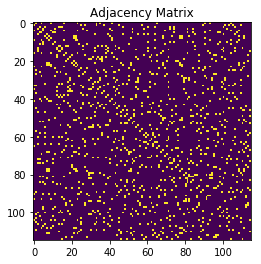

In [45]:
# number of nodes
N = G.number_of_nodes()
# select a train set and test set at random
# as it's being set now, 75% of the data is train, and 25% is test
tr_mask = torch.randint(0, 4, (N,))
tr_mask = tr_mask != 0
te_mask = tr_mask == 0

# build a target vector
# training samples will have -1 as their test labels, and vice versa
# that way, if I accidently leak data, the optimizer will break violently
tr_labels = -torch.ones(N, dtype=torch.int64)
te_labels = -torch.ones(N, dtype=torch.int64)

i = 0
for n in G.nodes:
    if tr_mask[i]:
        tr_labels[i] = G.nodes[n]['value']
    if te_mask[i]:
        te_labels[i] = G.nodes[n]['value']
    i = i + 1

# create an adjacency matrix
A = nx.to_numpy_matrix(G, nodelist=G.nodes())
plt.imshow(A)
plt.title('Adjacency Matrix');

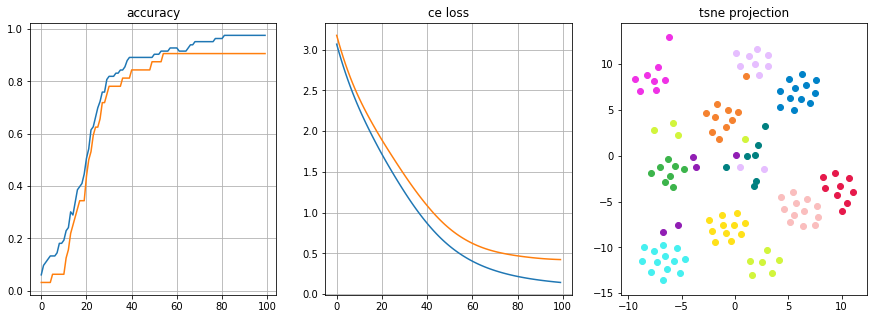

In [46]:
# gonna use more or less the same network as in the ZKC script

class GraphNet(torch.nn.Module):
    def __init__(self, N, A):
        super(GraphNet, self).__init__()
        temp = torch.randn((N, 24), dtype = torch.float64)
        self.W1 = torch.autograd.Variable(temp, requires_grad=True)
        temp = torch.randn((24, 12), dtype = torch.float64)
        self.W2 = torch.autograd.Variable(temp, requires_grad=True)
        
        A_h = A + np.eye(N)
        D = np.array(np.sum(A_h, axis=0))[0]
        D_i = np.diag(D ** (-0.5))
        DAD = D_i * A_h * D_i
        self.DAD = torch.tensor(DAD)
        
    def forward(self, x):
        x = torch.mm(self.DAD,x)
        x = torch.mm(x, self.W1)
        x = F.relu(x)
        x = torch.mm(self.DAD,x)
        x = torch.mm(x, self.W2)
        
        return x

# as with the karate club, just use a minimal feature vector
inputs = torch.tensor(np.eye(G.number_of_nodes()))

gcn = GraphNet(G.number_of_nodes(), A)

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([gcn.W1, gcn.W2], lr=1e-2)

epochs = 100
tr_loss = np.zeros(epochs)
te_loss = np.zeros(epochs)
tr_acc = np.zeros(epochs)
te_acc = np.zeros(epochs)

for e in range(epochs):    
    optimizer.zero_grad()
    output = gcn(inputs)
    loss = loss_func(output[tr_mask], tr_labels[tr_mask])
    loss.backward()
    optimizer.step()
    
    # compute predictons
    pred = torch.argmax(output, dim=1)
    # train loss
    tr_loss[e] = loss.detach().numpy()
    # calculate the train accuracy
    acc = (pred[tr_mask] == tr_labels[tr_mask]).sum().double() / tr_mask.sum()
    tr_acc[e] = acc.detach().numpy()
    # test loss
    loss = loss_func(output[te_mask], te_labels[te_mask])
    te_loss[e] = loss.detach().numpy()
    # calculate the test accuracy
    acc = (pred[te_mask] == te_labels[te_mask]).sum().double() / te_mask.sum()
    te_acc[e] = acc.detach().numpy()
    
# project the 12 dimensional output down to 2d via tsne for visualization    
output = output.detach().numpy()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(output)

fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(tr_acc)
axes[0].plot(te_acc)
axes[0].set_title('accuracy');
axes[0].grid()
axes[1].plot(tr_loss)
axes[1].plot(te_loss)
axes[1].set_title('ce loss');
axes[1].grid()
for i in range(G.number_of_nodes()):
    axes[2].scatter(tsne_results[i,0], tsne_results[i,1], color=cmap[i])
axes[2].set_title('tsne projection');


In [57]:
# I wonder what that one CUSA (orange) team which keeps getting classified with WAC (lavendar) is...
mask = ((pred == 11) & (tr_labels == 4)).detach().numpy()
ix = np.where(mask)[0][0]

# there's almost certainly a better way to do this part
i = 0
for n in G.nodes:
    if i == ix:
        break
    i = i + 1

print('misclassified node and opponents... ')
nbors = G.neighbors(n)
for ng in nbors:
    print(n + ' (' + str(G.nodes[n]['value']) + ')' + ' v ' + ng + ' (' + str(G.nodes[ng]['value']) + ')')
    
# HA! this is actually a mistake in the labels, TCU was part of the WAC in 2000, and should have value 11

misclassified node: TexasChristian
neighbors: 
TexasChristian (4) v Northwestern (2)
TexasChristian (4) v ArkansasState (10)
TexasChristian (4) v FresnoState (11)
TexasChristian (4) v Rice (11)
TexasChristian (4) v SouthernMethodist (11)
TexasChristian (4) v Nevada (11)
TexasChristian (4) v SanJoseState (11)
TexasChristian (4) v Navy (5)
TexasChristian (4) v TexasElPaso (11)
TexasChristian (4) v Tulsa (11)
TexasChristian (4) v Hawaii (11)
